In [1]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from IPython import get_ipython

# 定义全局变量
nthresholds = 100  # 在使用前定义

# 对于 matplotlib 的内联显示
get_ipython().run_line_magic('matplotlib', 'inline')

DATA_PATH = "./data"
with open(os.path.join(DATA_PATH, "stopwords.txt"), 'r') as file:
    stopwords = file.read()

amazon_df = pd.read_csv(os.path.join(DATA_PATH, "Amazon.csv"))
google_df = pd.read_csv(os.path.join(DATA_PATH, "Google.csv"))

In [2]:
import pandas as pd
import os

DATA_PATH = "./data"

# 读取完整映射文件
perfectMap_df = pd.read_csv(os.path.join(DATA_PATH, "Amazon_Google_perfectMapping.csv"))
perfectMap = []

def buildPerfectMap(x): 
    perfectMap.append((x['idAmazon'], x['idGoogleBase']))

perfectMap_df.apply(buildPerfectMap, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
1295    None
1296    None
1297    None
1298    None
1299    None
Length: 1300, dtype: object

In [3]:
import re
stopwords = stopwords.split('\n')
split_regex = r'\w+'
# TODO Implement this
"""
一：分割文本，得到有效Tokens
题目要求：
    读取Amazon.csv和Google.csv中的数据。
    对每条数据进行文本分割，得到tokens列表。
    读取stopwords.txt，去除停用词。
输入：
    Amazon.csv文件，Google.csv文件字符串
    stopwords.txt文件字符串
输出：
    Amazon数据集的tokens列表
    Google数据集的tokens列表
"""
def simple_tokenize(string):
    """
    简单分词函数，使用正则表达式提取单词
    """
    return re.findall(split_regex, string.lower())

def tokenize(string):
    """
    分词并去除停用词
    """
    tokens = simple_tokenize(string)
    return [token for token in tokens if token not in stopwords]

def rec2tok(x, dic):
    """
    将记录转换为tokens并存储在字典中
    """
    # 合并所有相关字段
    text = f"{x['title']} {x['description']}"
    tokens = tokenize(text)
    dic[x['id']] = tokens

In [4]:
# TODO Implement this
"""
二：求解TF,IDF,TF-IDF
题目要求：
    对每个数据集的tokens计算TF值。
    计算IDF值。
    根据TF和IDF计算TF-IDF。
输入：
    数据集的tokens列表
输出：
    数据集的TF-IDF字典
"""
def inc(i, dic):
    """
    增加字典中键i的计数
    """
    if i in dic:
        dic[i] += 1
    else:
        dic[i] = 1

def tf(tokens):
    """
    计算词频(TF)
    TF = 词在文档中出现的次数 / 文档中词的总数
    """
    tf_dict = {}
    total_tokens = len(tokens)  # 计算总token数
    
    # 统计每个token出现的次数
    for token in tokens:
        if token in tf_dict:
            tf_dict[token] += 1
        else:
            tf_dict[token] = 1
    
    # 归一化处理
    for token in tf_dict:
        tf_dict[token] = tf_dict[token] / total_tokens
        
    return tf_dict

def idf(rec2tok):
    """
    计算逆文档频率(IDF)
    """
    idf_dict = {}
    N = len(rec2tok)  # 文档总数
    
    # 统计每个词出现在多少文档中
    for doc_id in rec2tok:
        seen = set()  # 用于去重
        for token in rec2tok[doc_id]:
            if token not in seen:
                inc(token, idf_dict)
                seen.add(token)
    
    # 计算IDF值
    for token in idf_dict:
        idf_dict[token] = math.log(N / idf_dict[token])
    
    return idf_dict

def tfidf(tokens, idfs):
    """
    计算TF-IDF值
    """
    tfidf_dict = {}
    tf_dict = tf(tokens)
    
    for token in tf_dict:
        if token in idfs:
            tfidf_dict[token] = tf_dict[token] * idfs[token]
            
    return tfidf_dict
# TODO Implement this
"""
三：构建token与ID的逆向索引
题目要求：
    构建数据集的逆向索引。
输入：
    数据集的tokens列表
输出：
    数据集的逆向索引字典
"""
def invertIndex(forward_index):
    """
    构建倒排索引
    """
    inverted_index = {}
    for doc_id in forward_index:
        for token in set(forward_index[doc_id]):  # 使用set去重
            if token not in inverted_index:
                inverted_index[token] = []
            inverted_index[token].append(doc_id)
    return inverted_index


In [5]:
import math
# TODO Implement this
"""
四：题目要求：实现向量间点积方法
    输入：向量a与向量b
    输出：a和b点积的结果
"""
def dotprod(a, b):
    """
    优化的向量点积计算
    """
    sum = 0.0
    # 只考虑较重要的tokens（TF-IDF值较高的）
    threshold = 0.1  # 设置一个阈值来过滤低权重的tokens
    for key in a:
        if key in b and a[key] > threshold and b[key] > threshold:
            sum += a[key] * b[key]
    return sum

def norm(a):
    """
    计算向量的模长
    """
    return math.sqrt(sum(x*x for x in a.values()))


In [6]:
amazon_rec2tok = {}
google_rec2tok = {}

amazon_df.apply(lambda x:rec2tok(x,amazon_rec2tok),axis=1)
google_df.apply(lambda x:rec2tok(x,google_rec2tok),axis=1)

amazon_inv=invertIndex(amazon_rec2tok)

In [7]:
from collections import Counter
idfs_full = dict(Counter(idf(amazon_rec2tok))+Counter(idf(google_rec2tok)))
google_weights={i:tfidf(google_rec2tok[i],idfs_full) for i in google_rec2tok}
amazon_weights={i:tfidf(amazon_rec2tok[i],idfs_full) for i in amazon_rec2tok}
google_norm={i:norm(google_weights[i]) for i in google_weights}
amazon_norm={i:norm(amazon_weights[i]) for i in amazon_weights}

In [8]:
def buildSim(Id, weight, norm, weights, norms, inv, sims):
    """
    构建相似度
    """
    for i in weight:
        if i in inv:
            for j in inv[i]:
                if not (j,Id) in sims:
                    # 确保分母不为0
                    if norm == 0 or norms[j] == 0:
                        continue
                    # 计算余弦相似度
                    similarity = dotprod(weight, weights[j]) / (norm * norms[j])
                    # 确保相似度在[0,1]范围内
                    similarity = max(0, min(1, similarity))
                    sims[(j,Id)] = similarity

In [9]:
sims={}
for i in google_weights:
    buildSim(i,google_weights[i],google_norm[i],amazon_weights,amazon_norm,amazon_inv,sims)

In [10]:
print(len(sims))

2287074


In [11]:
true_dup_sims = []
def truepos(threshold):
    global true_dup_sims
    true_dup_sims=[]
    for i in sims:
        if sims[i]>threshold: 
            true_dup_sims.append(i)
def bin(similarity):
    return int(similarity * nthresholds)

# TODO Implement this
def falsepos(threshold):
    ans=0
    for i in true_dup_sims:
        if not i in perfectMap: ans+=1
    return ans
# TODO Implement this (returns a float)
def precision(threshold):
    truepos(threshold)
    true_positives = len(true_dup_sims) - falsepos(threshold)
    total_predictions = len(true_dup_sims) if len(true_dup_sims) > 0 else 1
    return true_positives / total_predictions


thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]  # 调整范围

In [12]:

p=[precision(n) for n in thresholds]


# 在这里添加调试代码
threshold = 0.84
truepos(threshold)
print(f"阈值{threshold}时的匹配对数量：", len(true_dup_sims))
print(f"其中错误匹配数量：", falsepos(threshold))

threshold = 0.85
truepos(threshold)
print(f"阈值{threshold}时的匹配对数量：", len(true_dup_sims))
print(f"其中错误匹配数量：", falsepos(threshold))

# 继续原有的绘图代码

阈值0.84时的匹配对数量： 83
其中错误匹配数量： 30
阈值0.85时的匹配对数量： 78
其中错误匹配数量： 28


最大精确率： 0.6410256410256411
最大精确率阈值： 0.85


/Users/zhangyibo/miniconda3/envs/entity_match/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from current font.
  func(*args, **kwargs)
/Users/zhangyibo/miniconda3/envs/entity_match/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from current font.
  func(*args, **kwargs)
/Users/zhangyibo/miniconda3/envs/entity_match/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  func(*args, **kwargs)
/Users/zhangyibo/miniconda3/envs/entity_match/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from current font.
  func(*args, **kwargs)
/Users/zhangyibo/miniconda3/envs/entity_match/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) m

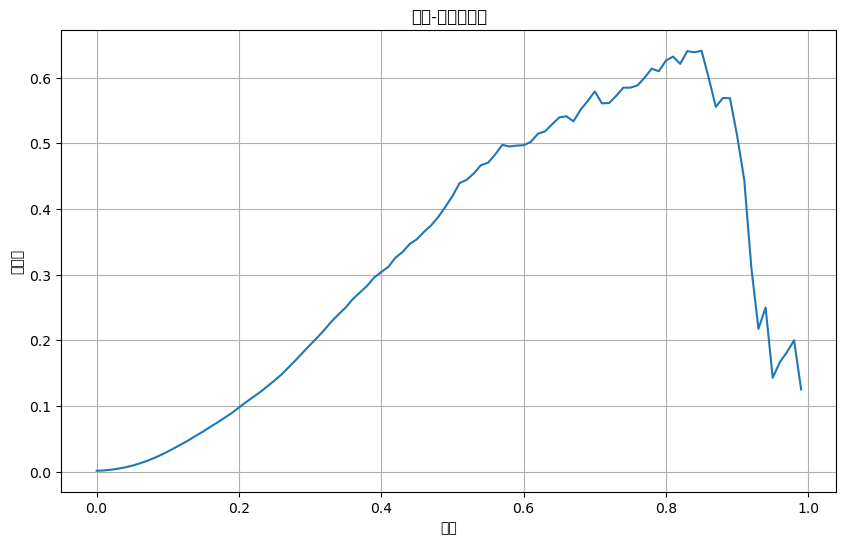

In [13]:
# 替换 %pylab inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(thresholds, p)
plt.grid(True)
plt.xlabel('阈值')
plt.ylabel('精确率')
plt.title('阈值-精确率曲线')

# 找出最大精确率及其阈值
max_precision_idx = p.index(max(p))
print("最大精确率：", max(p))
print("最大精确率阈值：", thresholds[max_precision_idx])